In [8]:
# Module load
from classifier_embedding import *
from classifier_model import *

ImportError: cannot import name 'load_data_to_embed' from 'classifier_embedding' (/data2/julia/PLM/classifier/classifier_embedding.py)

# EMBEDDINGS

In [7]:
# Load the data
df = load_data_to_embed('data_retrospective/IL36g_retrospective.csv', sep=',')
compound_df = df.copy()

NameError: name 'load_data_to_embed' is not defined

In [ ]:
# 1. Embed molecules
print('\nEmbedding SMILES to ChemBERTa embedding v2...\n')
ddf = dd.from_pandas(compound_df, npartitions=6) # number of cores to parallelize
ddf['chembert2'] = ddf['SMILES'].apply(smiles_to_chemberta, model_version='v2')
compound_df = ddf.compute()
print(compound_df)
compound_df.to_pickle('data_retrospective/compound_df.pkl')

In [ ]:
# 2. Embed proteins
print('\nEmbedding protein sequences to ESM...\n')
compound_df = pd.read_pickle('data_retrospective/compound_df.pkl')
print(compound_df)
new_compound_df = protseqs_to_esm(prots_df=compound_df, col_seq='Target_seq', col_id='Target_ID', esm_model='650M')
print(new_compound_df)
new_compound_df.to_csv('data_retrospective/new_compound_df.csv')
new_compound_df.to_pickle('data_retrospective/new_compound_df.pkl')

In [ ]:
# 3. Make coembedding protein-compounds
print('\nCoembedding proteins and compounds...\n')
new_compound_df = pd.read_pickle('data_retrospective/new_compound_df.pkl')
new_compound_df['coembed'] = new_compound_df.apply(lambda x: coembedding(x['esm'], x['chembert2']), axis = 1)
print(new_compound_df)

In [ ]:
# store embeddings
new_compound_df.to_csv('data_retrospective/data_embed.csv')
new_compound_df.to_pickle('data_retrospective/data_embed.pkl')

# MODEL

In [5]:
# Fix Model to XGBoost
model_name = 'XGB'
model_class = XGBClassifier(n_estimators=5000, device='cuda:0')
# Fix Protein Embedding to ESM650M and Compound Embedding to ChemBERTa
# Fix percentage of undersampling to 0.5
percentage = 0.5


# Load the data from IL36g retrospective target
SEED = 1234
# Load data
df = load_data_to_model(pickle_file='data_retrospective/data_embed.pkl')


Original dataset:
 - Number of active compounds:  7432
 - Number of inactive compounds (decoys):  141195


In [6]:
# Undersampling
X = df['coembed'].tolist()
Y = df['Label'].tolist()
X_res, Y_res = undersampling(Y, X, percentage=percentage)
df_res = pd.DataFrame({'coembed': X_res, 'Label': Y_res})

Undersampling:
 - Original dataset shape Counter({0: 141195, 1: 7432})
 - Resampled dataset shape Counter({0: 14864, 1: 7432})


/data/miniconda3/envs/PLM/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:05:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Mean accuracy: 0.85 	and std : 0.00 
Mean sensitivity: 0.76 	and std : 0.01 
Mean specificity: 0.90 	and std : 0.00 
Mean AUC: 0.92 	and std : 0.00 
Mean precision: 0.78 	and std : 0.01 
Mean f1: 0.77 	and std : 0.01 
Time taken : 282.01s



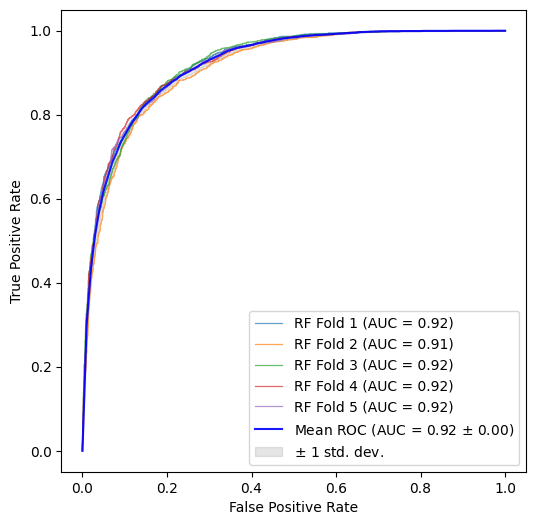

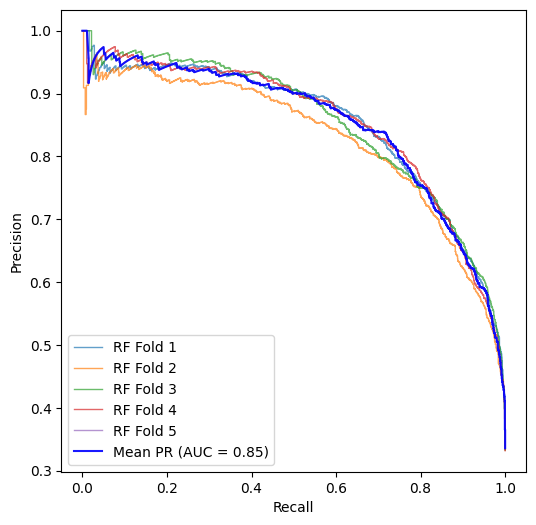

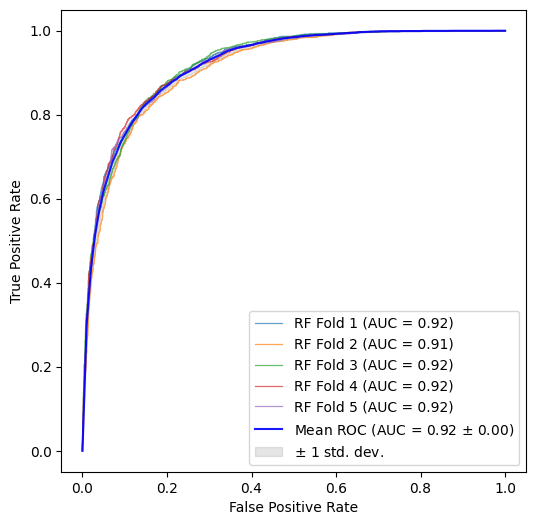

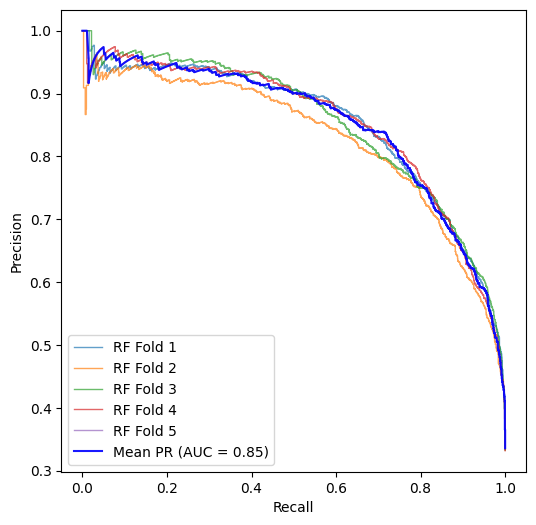

In [7]:
# Cross-validation
N_FOLDS = 5
statistics_list, plot_metrics = crossvalidation(model_class, df_res, n_folds=N_FOLDS, seed=SEED, verbose=False, plot_roc_xf=True, plot_pr_xf=True)


In [10]:
# Results
df_statistics = pd.DataFrame(statistics_list, columns=['IL36g'])
index_names =['acc_mean', 'acc_std', 'sens_mean', 'sens_std',
                'spec_mean', 'spec_std', 'auc_mean', 'auc_std',
                'precision_mean', 'precision_std', 'f1_mean', 'f1_std', 'time']
df_statistics.index = index_names
df_statistics.to_csv('data_retrospective/statistics_IL36g.csv')
df_statistics

,IL36g
acc_mean,0.850018
acc_std,0.004887
sens_mean,0.758760
sens_std,0.011687
spec_mean,0.895658
spec_std,0.003131
auc_mean,0.919389
auc_std,0.004452
precision_mean,0.784272
precision_std,0.006736
